This notebook simulates the governing equation to find the output correlation matrix of the biphotons given an input. The governing equation is:

\begin{equation}
    \Theta_{out}(t\rightarrow +\infty) = \tilde{\Theta}_{in}(z=0). W^\dagger + W \cdot \tilde{\Theta}_{in}(z=0) + S \tilde{\Theta}_{in}(z=0) S^\dagger \cdot W + W^\dagger \cdot S \tilde{\Theta}_{in}(z=0)S^\dagger + \Theta_{in}(t\rightarrow -\infty)
\end{equation}

Import all libraries

In [48]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

Important functions for unit conversions

In [64]:
# --------------------------------------------------------------
#  FUNCTIONS FOR UNIT CONVERSIONS
# --------------------------------------------------------------

def lambda_to_freq(lam):
    return 3e8 / (lam * 1e-9) * 1e-12  # THz

def freq_to_lambda(freq):
    return 3e8 / (freq * 1e12) * 1e9  # nm

def THz_to_meV(freq):
    return 6.62 * 6.24 * 0.1 * freq   # me
     
def freq(x):
    # wavelength in nm to frequency in Hz
    w = 1239.8 / (x*4.136*10**(-15))
    return w

# --------------------------------------------------------------
#  FUNCTION TO GENERATE MATRICES
# --------------------------------------------------------------

def compute_W(g, n, kappa, freq_points, omega_c, Omega):
    W = np.zeros((2*n+2, 2*n+2), dtype=complex)
    np.fill_diagonal(W[:n, :n], -1j * freq_points)
    np.fill_diagonal(W[n:2*n, n:2*n], -1j * freq_points)
    W[2*n, 2*n] = -1j * omega_c - gamma / 2
    W[2*n+1, 2*n+1] = -1j * Omega
    W[2*n, :2*n] = -1j * g
    W[:2*n, 2*n] = -1j * g
    W[2*n, 2*n+1] = -np.sqrt(kappa)
    W[2*n+1, 2*n] = -np.sqrt(kappa)
    return W

def theta_derivative(t, Theta_flat):
    Theta = Theta_flat.reshape(2*n+2, 2*n+2)
    dTheta_dt = W @ Theta + Theta @ W.conj().T
    return dTheta_dt.flatten()

def theta_derivative_2(t, Theta_flat, W):
    Theta = Theta_flat.reshape(2*n+2, 2*n+2)
    dTheta_dt = W @ Theta + Theta @ W.conj().T
    return dTheta_dt.flatten()

def schmidt_decomposition_entropy(matrix):
    U, S, Vh = np.linalg.svd(matrix)
    p = S**2 / np.sum(S**2)
    entropy = -np.sum(p * np.log(p + 1e-12))  # Small term to avoid log(0)
    return S, entropy
    
def schmidt_decomposition_entropy_2(matrix):
    U, S, Vh = np.linalg.svd(matrix)
    p = S**2 / np.sum(S**2)
    entropy = -np.sum(p * np.log(p + 1e-12))  # Small term to avoid log(0)
    return entropy
# --------------------------------------------------------------
#  FUNCTION TO GENERATE THEORETICAL JSA
# --------------------------------------------------------------

def generate_JSA(n, freq_points):

    X, Y = np.meshgrid(freq_points, freq_points)

    x_min = np.min(freq_points)
    x_max = np.max(freq_points)
    y_min = np.min(freq_points)
    y_max = np.max(freq_points)

    x0 = lambda_to_freq(682)
    y0 = lambda_to_freq(692)
    print(f"freq_idler center: {THz_to_meV(x0)}")
    print(f"freq signal center: {THz_to_meV(y0)}")

    # x0, y0 = (x_max + x_min) / 2, (y_max + y_min) / 2  
    sigma_x, sigma_y = 3, 3  
    correlation = 2 # Controls the squeezing along the diagonal

    # Rotation transformation to align Gaussian along off-diagonal
    X_rot = (X - x0) * np.cos(np.pi/4) + (Y - y0) * np.sin(np.pi/4)
    Y_rot = -(X - x0) * np.sin(np.pi/4) + (Y - y0) * np.cos(np.pi/4)

    JSA = np.exp(-((X_rot)**2 / (2 * sigma_x**2) + (Y_rot**2 / (2 * (sigma_y * correlation)**2))))
    JSI = JSA**2 
    JSI = np.abs(JSI)/np.max(JSI)

    return JSI

def generate_JSA_2(n, freq_points):

    X, Y = np.meshgrid(freq_points, freq_points)

    x_min = np.min(freq_points)
    x_max = np.max(freq_points)
    y_min = np.min(freq_points)
    y_max = np.max(freq_points)

    x0 = lambda_to_freq(680)
    y0 = lambda_to_freq(695)
    # x0, y0 = (x_max + x_min) / 2, (y_max + y_min) / 2  
    sigma_x, sigma_y = 3, 3  
    correlation = 2 # Controls the squeezing along the diagonal

    # Rotation transformation to align Gaussian along off-diagonal
    X_rot = (X - x0) * np.cos(np.pi/4) + (Y - y0) * np.sin(np.pi/4)
    Y_rot = -(X - x0) * np.sin(np.pi/4) + (Y - y0) * np.cos(np.pi/4)

    JSA = np.exp(-((X_rot)**2 / (2 * sigma_x**2) + (Y_rot**2 / (2 * (sigma_y * correlation)**2))))
    JSI = JSA**2 
    JSI = np.abs(JSI)/np.max(JSI)

    return JSI    

Import data files. Credit to the code block below goes to Kandada and collaborators

In [50]:
## BBO data

wave_old = np.loadtxt('../data/wave_old.txt')
wave_new = np.loadtxt('../data/wave_new.txt')
FT = np.loadtxt('../data/FT.txt', delimiter=',', dtype=np.complex128)

## empty microcavity data

wave_old2 = np.loadtxt('../data/wave_old2.txt')
wave_new2 = np.loadtxt('../data/wave_new2.txt')
FT2 = np.loadtxt('../data/FT2.txt', delimiter=',', dtype=np.complex128)

Constants and Parameters

In [51]:
scaling_factor = 1000

Run the simulation

In [52]:
output_dir = "../images/JSI"
os.makedirs(output_dir, exist_ok=True)

x = lambda_to_freq(wave_old) / scaling_factor
y = lambda_to_freq(wave_new) / scaling_factor

JSA = np.sqrt(FT) / np.linalg.norm(np.sqrt(FT), "fro")

g = 425 / scaling_factor
omega_c = 425 / scaling_factor
Omega = 425 / scaling_factor
gamma = 0
n = len(FT)
freq_points = x
t_values = np.linspace(1, 10, 10)  
t_span = (t_values[0], t_values[-1])  

kappa_values = [0, 2000, 4000, 8000]

theta_0 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0, 0.5)
theta_0[n:2*n, :n] = JSA
theta_0[:n, n:2*n] = JSA.T

for idx, kappa in enumerate(kappa_values):
    kappa /= scaling_factor
    W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
    S = W.conj().T @ np.linalg.inv(W)  

    sol = solve_ivp(theta_derivative, t_span, theta_0.flatten(), t_eval=t_values)
    tilde_Theta_in = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
    tilde_Theta_in /= np.linalg.norm(tilde_Theta_in, "fro")

    A = (tilde_Theta_in @ W.conj().T + W @ tilde_Theta_in +
         S @ tilde_Theta_in @ S.conj().T @ W + W.conj().T @ S @ tilde_Theta_in @ S.conj().T)

    Theta_out = theta_0 + A
    JSA_out = Theta_out[n:2*n, :n]
    JSI_out = np.abs(JSA_out)**2 / np.max(np.abs(JSA_out)**2)

    x_plot = freq_to_lambda(x * scaling_factor)
    y_plot = freq_to_lambda(y * scaling_factor)

    fig, ax = plt.subplots(figsize=(7, 6))
    c = ax.contourf(x_plot, y_plot, JSI_out, levels=50, cmap="viridis")
    contours = ax.contour(x_plot, y_plot, JSI_out, levels=10, colors='black', linewidths=0.8)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
    ax.set_aspect('equal')

    ax.set_ylabel("Signal Wavelength (nm)")
    ax.set_xlabel("Idler Wavelength (nm)")

    kappa_meV = THz_to_meV(np.sqrt(kappa * scaling_factor))
    ax.set_title(f"√κ={kappa_meV:.2f} meV")

    cbar = fig.colorbar(c, ax=ax)

    filename = f"JSI_kappa_{kappa_meV}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)
    plt.close(fig)


Calculate and plot the entropy of the outgoing photon states

In [54]:
x = lambda_to_freq(wave_old) / scaling_factor
y = lambda_to_freq(wave_new) / scaling_factor

JSA = np.sqrt(FT) / np.linalg.norm(np.sqrt(FT), "fro")

g = 440 / scaling_factor
omega_c = 440 / scaling_factor
Omega = 440 / scaling_factor
gamma = 0
n = len(FT)
freq_points = x
t_values = np.linspace(1, 10, 10)  
t_span = (t_values[0], t_values[-1])  

kappa_values = np.linspace(0,6000,20)
entropy_out_list = []
theta_0 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0, 0.5)
theta_0[n:2*n, :n] = JSA
theta_0[:n, n:2*n] = JSA.T

for idx, kappa in enumerate(kappa_values):
    kappa /= scaling_factor
    W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
    S = W.conj().T @ np.linalg.inv(W)  

    sol = solve_ivp(theta_derivative, t_span, theta_0.flatten(), t_eval=t_values)
    tilde_Theta_in = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
    tilde_Theta_in /= np.linalg.norm(tilde_Theta_in, "fro")

    A = (tilde_Theta_in @ W.conj().T + W @ tilde_Theta_in +
         S @ tilde_Theta_in @ S.conj().T @ W + W.conj().T @ S @ tilde_Theta_in @ S.conj().T)

    Theta_out = theta_0 + A
    JSA_out = Theta_out[n:2*n, :n]
    JSI_out = np.abs(JSA_out)**2 / np.max(np.abs(JSA_out)**2)
    schmidt_coeffs_out, entropy_out = schmidt_decomposition_entropy(JSA_out)
    entropy_out_list.append(entropy_out)

    print(f"Von Neumann Entropy of output: {entropy_out}")


Von Neumann Entropy of output: 0.48147657176208236
Von Neumann Entropy of output: 0.481800232557792
Von Neumann Entropy of output: 0.48132116532297453
Von Neumann Entropy of output: 0.48006503374237497
Von Neumann Entropy of output: 0.4780729286470523
Von Neumann Entropy of output: 0.4754112941429322
Von Neumann Entropy of output: 0.4721502766693548
Von Neumann Entropy of output: 0.4683804762345199
Von Neumann Entropy of output: 0.46419777002282736
Von Neumann Entropy of output: 0.459696065746454
Von Neumann Entropy of output: 0.4549877154922142
Von Neumann Entropy of output: 0.45015899261933895
Von Neumann Entropy of output: 0.4453235930369124
Von Neumann Entropy of output: 0.440578662209936
Von Neumann Entropy of output: 0.4360020822010317
Von Neumann Entropy of output: 0.431699790406912
Von Neumann Entropy of output: 0.42773618760205717
Von Neumann Entropy of output: 0.4241923757814474
Von Neumann Entropy of output: 0.42113470270642034
Von Neumann Entropy of output: 0.41865312099185

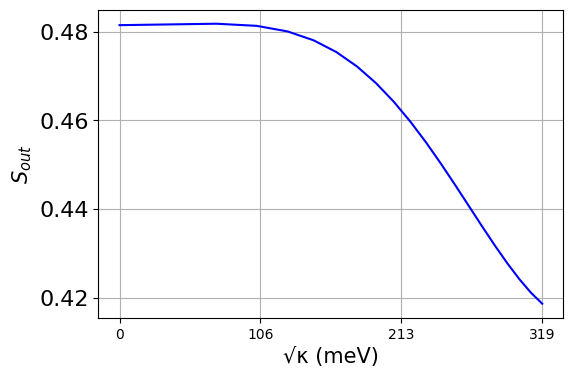

In [55]:
# --------------------------------
#   PLOTTING ENTROPY vs. KAPPA
# --------------------------------

plt.figure(figsize=(6, 4))
kappa_meV = THz_to_meV(np.sqrt(kappa_values))
plt.plot(kappa_meV, entropy_out_list, linestyle='-', color='b')

num_ticks = 4
kappa_ticks = np.linspace(kappa_meV[0], kappa_meV[-1], num_ticks)

# Set the ticks directly from kappa_values
plt.xticks(kappa_ticks, [f'{int(k)}' for k in kappa_ticks], fontsize=10)

plt.xlabel(f"√κ (meV)", fontsize=15)
plt.ylabel('$S_{out}$', fontsize=15)
plt.grid()
plt.show()

In [57]:
entropy_out_list_2 = []
theta_0 = np.zeros((2*n+3, 2*n+3), dtype=complex)
np.fill_diagonal(theta_0, 0.5)
theta_0[n:2*n, :n] = JSA
theta_0[:n, n:2*n] = JSA.T

def compute_W(g, n, kappa, freq_points, omega_c, Omega):
    W = np.zeros((2*n+3, 2*n+3), dtype=complex)
    np.fill_diagonal(W[:n, :n], -1j * freq_points)
    np.fill_diagonal(W[n:2*n, n:2*n], -1j * freq_points)
    W[2*n, 2*n] = -1j * omega_c
    W[2*n+1, 2*n+1] = -1j * Omega
    W[2*n+2, 2*n+2] = -1j * Omega
    W[2*n, :2*n] = -1j * g
    W[:2*n, 2*n] = -1j * g
    W[2*n, 2*n+1] = -np.sqrt(kappa)
    W[2*n+1, 2*n] = -np.sqrt(kappa)
    W[2*n, 2*n+2] = -np.sqrt(kappa)
    W[2*n+2, 2*n] = -np.sqrt(kappa)
    return W

for idx, kappa in enumerate(kappa_values):
    kappa /= scaling_factor
    W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
    S = W.conj().T @ np.linalg.inv(W)  

    sol = solve_ivp(theta_derivative, t_span, theta_0.flatten(), t_eval=t_values)
    tilde_Theta_in = sum(sol.y[:, i].reshape(2*n+3, 2*n+3) for i in range(len(t_values)))
    tilde_Theta_in /= np.linalg.norm(tilde_Theta_in, "fro")

    A = (tilde_Theta_in @ W.conj().T + W @ tilde_Theta_in +
         S @ tilde_Theta_in @ S.conj().T @ W + W.conj().T @ S @ tilde_Theta_in @ S.conj().T)

    Theta_out = theta_0 + A
    JSA_out = Theta_out[n:2*n, :n]
    JSI_out = np.abs(JSA_out)**2 / np.max(np.abs(JSA_out)**2)
    schmidt_coeffs_out, entropy_out = schmidt_decomposition_entropy(JSA_out)
    entropy_out_list_2.append(entropy_out)

    print(f"Von Neumann Entropy of output: {entropy_out}")

Von Neumann Entropy of output: 0.48147657176208264
Von Neumann Entropy of output: 0.48132404246743865
Von Neumann Entropy of output: 0.47808174007058446
Von Neumann Entropy of output: 0.4721693980365845
Von Neumann Entropy of output: 0.4642295827254175
Von Neumann Entropy of output: 0.4550314266803904
Von Neumann Entropy of output: 0.4453738758003485
Von Neumann Entropy of output: 0.4360577423794295
Von Neumann Entropy of output: 0.4277754963355571
Von Neumann Entropy of output: 0.42117036261918256
Von Neumann Entropy of output: 0.41683782968384037
Von Neumann Entropy of output: 0.41537911806340494
Von Neumann Entropy of output: 0.4172852823603222
Von Neumann Entropy of output: 0.4227347137313404
Von Neumann Entropy of output: 0.4313837089562474
Von Neumann Entropy of output: 0.4420849932092149
Von Neumann Entropy of output: 0.4528846773992887
Von Neumann Entropy of output: 0.46172970713962647
Von Neumann Entropy of output: 0.46691282506307585
Von Neumann Entropy of output: 0.467875234

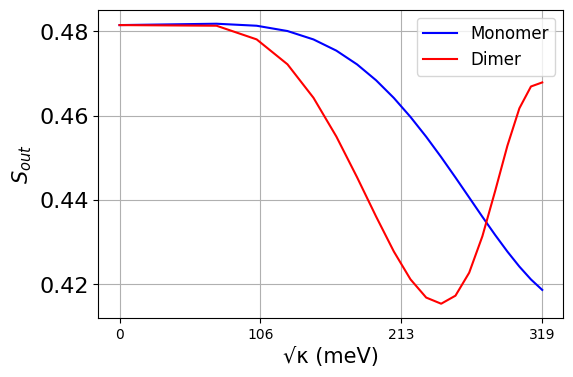

In [58]:
output_dir = "../images/entropy"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(6, 4))
kappa_meV = THz_to_meV(np.sqrt(kappa_values))

plt.plot(kappa_meV, entropy_out_list, linestyle='-', color='b', label="Monomer")
plt.plot(kappa_meV, entropy_out_list_2, linestyle='-', color='r', label="Dimer")

num_ticks = 4
kappa_ticks = np.linspace(kappa_meV[0], kappa_meV[-1], num_ticks)

# Set the ticks directly from kappa_values
plt.xticks(kappa_ticks, [f'{int(k)}' for k in kappa_ticks], fontsize=10)

plt.xlabel(f"√κ (meV)", fontsize=15)
plt.ylabel('$S_{out}$', fontsize=15)
plt.grid()
plt.legend(fontsize=12)  # Adding legend with readable font size

filename = f"entropy_expt.png"
filepath = os.path.join(output_dir, filename)
fig.savefig(filepath, dpi=300, bbox_inches='tight')
plt.close(fig)

Plot the experimental input and output. 

Credit for most part of the code block below goes to Kandada and collaborators.

In [60]:
output_dir = "../images/expt_plts"
os.makedirs(output_dir, exist_ok=True)

lambda0 = 685 # nm
w0 = freq(lambda0) # central downconverted frequency

x = np.arange(675.0, 700.0, 0.02)
y = np.arange(675.0, 700.0, 0.02)

x1 = np.arange(660.0, 710.0, 0.02)

sig = freq(688)-freq(682)

#check filter shape
z = np.exp(-((freq(x)-w0)**4)/(2*sig**4))

X, Y = np.meshgrid(x, y)

vs = freq(X) - w0
vi = freq(Y) - w0

Z = np.exp(-(vi**2+vs**2)/(2*sig**2))*np.exp(-(2*vs*vi)/(2*sig**2))

detection_filter = np.exp(-((vs)**4)/(2*(freq(685)-freq(675))**4))*np.exp(-((vi)**4)/(2*(freq(685)-freq(675))**4))

Z = Z*detection_filter


gamma = 1 / 0.00000000000015
cav = 690 # cavity mode in nm


## two-sided cavity from Gardiner and Collett
## assuming uni-directional input and equal mirrors (a_in = 0)
output2 = gamma/(gamma + 1j*(freq(X)-freq(cav)))
Z2 = Z*output2

fig = plt.figure(figsize=(12, 12), dpi=300)  # Bigger and higher resolution
colornorm = mpl.colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
plt.rcParams.update({'font.size': 16})  # Default font size bump

gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1,1])

ax1 = fig.add_subplot(gs[0,0], box_aspect=1)
ax2 = fig.add_subplot(gs[0,1], box_aspect=1, sharey=ax1)

# Plot data
cf1 = ax1.contourf(wave_old[:], wave_new[:], np.abs(FT)/np.max(np.abs(FT)), cmap='viridis', levels=60)
ax1.set_ylabel('Signal wavelength (nm)', fontsize=22)
ax1.set_xlabel("Idler wavelength (nm)", fontsize=22)
ax1.set_xticks([675, 680, 685, 690, 695])    
ax1.set_ylim(675, 700)

# Remove the first tick on the y-axis
ax1.set_yticks(ax1.get_yticks()[1:])  # Skip the first y-tick

cf2 = ax2.contourf(wave_old2[:], wave_new2[:], np.abs(FT2)/np.max(np.abs(FT2)), cmap='viridis', levels=60)
ax2.set_xlabel("Idler wavelength (nm)", fontsize=22)

ax2.set_xlim(675, 700)
ax2.set_ylim(675, 700)

# Improve tick sizes
ax1.tick_params(labelbottom=True, labelsize=18)
ax2.tick_params(labelbottom=True, labelleft=False, labelsize=18)

# Colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=colornorm)
sm.set_array([])

cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.38])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Normalized JSI", fontsize=22)
cbar.ax.tick_params(labelsize=18)

# Layout tweaks
plt.subplots_adjust(hspace=0, wspace=0.08)

# # Save with better DPI and layout
filename = f"experimental_JSI.png"
filepath = os.path.join(output_dir, filename)
fig.savefig(filepath, dpi=300, bbox_inches='tight')
plt.close(fig)


Plot the theoretical squeezed gaussian input and output

In [65]:
output_dir = "../images/JSI"
os.makedirs(output_dir, exist_ok=True)

# --------------------------------------------------------------
#  PARAMETERS
# --------------------------------------------------------------

g =  lambda_to_freq(685) / scaling_factor                           # Bath-Cavity coupling strength
omega_c = lambda_to_freq(685) / scaling_factor
Omega = lambda_to_freq(685) / scaling_factor
print(f"g: {THz_to_meV(g*scaling_factor)}")
print(f"omega_c: {THz_to_meV(omega_c*scaling_factor)}")
print(f"Omega: {THz_to_meV(Omega*scaling_factor)}")
gamma = 0
n = 100
freq_min = lambda_to_freq(700) / scaling_factor
freq_max = lambda_to_freq(675) / scaling_factor
freq_points = np.linspace(freq_min, freq_max, n)
kappa = 14000 / scaling_factor                       # Cavity-spin coupling strength      
t_values = np.linspace(1, 10, 10)  
t_span = (t_values[0], t_values[-1])  

# ---------------------------------------------------------------
#   INITIAL CORRELATION MATRIX 
# ---------------------------------------------------------------

JSI = generate_JSA(n, freq_points * scaling_factor)
theta_0 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0, 0.5)
theta_0[n:2*n, :n] = np.sqrt(JSI)
theta_0[:n, n:2*n] = np.sqrt(JSI).T

# ---------------------------------------------------------------
#   SOLVING THE DYNAMICS
# ---------------------------------------------------------------

W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
W_dagger = W.conj().T
S = W.conj().T @ np.linalg.inv(W)  

sol = solve_ivp(theta_derivative, t_span, theta_0.flatten(), t_eval=t_values)
tilde_Theta_in = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
norm_theta = np.linalg.norm(tilde_Theta_in, "fro")
tilde_Theta_in = tilde_Theta_in / norm_theta

A = (tilde_Theta_in @ W.conj().T + W @ tilde_Theta_in + S @ tilde_Theta_in @ S.conj().T @ W + W.conj().T @ S @ tilde_Theta_in @ S.conj().T)
    
Theta_out = theta_0 + A
    
JSI_in = theta_0[n:2*n, :n] ** 2
JSA_out = Theta_out[n:2*n, :n]
JSI_out = np.abs(JSA_out)**2
JSI_out = np.abs(JSI_out)/np.max(np.abs(JSI_out))

# ------------------ PLOTTING IN WAVELENGTH SPACE ----------------

fig = plt.figure(figsize=(12, 12), dpi=300)  # Bigger and higher resolution
colornorm = mpl.colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
plt.rcParams.update({'font.size': 16})  # Default font size bump

gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Create the subplots with equal aspect ratio
ax1 = fig.add_subplot(gs[0, 0], box_aspect=1)
ax2 = fig.add_subplot(gs[0, 1], box_aspect=1, sharey=ax1)

# Plot initial JSI (Left figure)
x = freq_to_lambda(freq_points * scaling_factor)
y = freq_to_lambda(freq_points * scaling_factor)
c1 = ax1.contourf(x, y, JSI_in, levels=50, cmap="viridis")
contours1 = ax1.contour(x, y, JSI_in, levels=18, colors='black', linewidths=0.8)
ax1.set_xlabel("Idler Wavelength (nm)", fontsize=22)
ax1.set_ylabel("Signal Wavelength (nm)", fontsize=22)
ax1.set_xticks([675, 680, 685, 690, 695])
ax1.set_ylim(675, 700)
ax1.set_xlim(675, 700)

# Remove the first tick on the y-axis for left plot
ax1.set_yticks(ax1.get_yticks()[1:])  # Skip the first y-tick

# Plot final JSI (Right figure)
c2 = ax2.contourf(x, y, JSI_out, levels=50, cmap="viridis")
contours2 = ax2.contour(x, y, JSI_out, levels=18, colors='black', linewidths=0.8)
ax2.set_xlabel("Idler Wavelength (nm)", fontsize=22)
ax2.set_xlim(675, 700)
ax2.set_ylim(675, 700)

# Remove y-axis label and ticks for the right plot
ax2.set_ylabel('')
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Improve tick sizes for both plots
ax1.tick_params(labelbottom=True, labelsize=18)
ax2.tick_params(labelbottom=True, labelleft=False, labelsize=18)

# Colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=colornorm)
sm.set_array([])

cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.38])  # Adjust the position of colorbar
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Normalized JSI", fontsize=22)
cbar.ax.tick_params(labelsize=18)

# Layout tweaks to improve spacing between the plots
plt.subplots_adjust(hspace=0, wspace=0.08)

# Save the plot with better DPI and layout
filename = f"theoretical_JSI.png"
filepath = os.path.join(output_dir, filename)
fig.savefig(filepath, dpi=300, bbox_inches='tight')
plt.close(fig)


g: 1809.1445255474455
omega_c: 1809.1445255474455
Omega: 1809.1445255474455
freq_idler center: 1817.1026392961878
freq signal center: 1790.8439306358382


/home/sameer/anaconda3/envs/quantum_algorithms/lib/python3.12/site-packages/matplotlib/contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/home/sameer/anaconda3/envs/quantum_algorithms/lib/python3.12/site-packages/matplotlib/contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/home/sameer/anaconda3/envs/quantum_algorithms/lib/python3.12/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


Calculate entropy of squeezed gaussian output

In [45]:
g =  lambda_to_freq(685) / scaling_factor                           # Bath-Cavity coupling strength
omega_c = lambda_to_freq(685) / scaling_factor
Omega = lambda_to_freq(685) / scaling_factor
gamma = 0
n = 100
freq_min = lambda_to_freq(700) / scaling_factor
freq_max = lambda_to_freq(675) / scaling_factor
freq_points = np.linspace(freq_min, freq_max, n)
kappa = 10000 / scaling_factor                       # Cavity-spin coupling strength      
t_values = np.linspace(1, 10, 10)  
t_span = (t_values[0], t_values[-1])  

# ---------------------------------------------------------------
#   INITIAL CORRELATION MATRIX 
# ---------------------------------------------------------------

JSI = generate_JSA(n, freq_points * scaling_factor)
theta_0 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0, 0.5)
theta_0[n:2*n, :n] = np.sqrt(JSI)
theta_0[:n, n:2*n] = np.sqrt(JSI).T

JSI_2 = generate_JSA_2(n, freq_points * scaling_factor)
theta_0_2 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0_2, 0.5)
theta_0_2[n:2*n, :n] = np.sqrt(JSI_2)
theta_0_2[:n, n:2*n] = np.sqrt(JSI_2).T

# --------------------------------------------------------------
#  COMPUTE ENTROPY FOR VARYING kappa
# --------------------------------------------------------------

kappa_values = np.linspace(0, 30000, 20) / scaling_factor
entropies = []
entropies_2 = []

for kappa in kappa_values:
    W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
    sol = solve_ivp(theta_derivative_2, t_span, theta_0.flatten(), args=(W,), dense_output=True)
    sol_y_interp = np.array([sol.sol(t) for t in t_values]).T

    print(sol.y.shape)
    
    # Compute Theta_out
    tilde_Theta_in = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
    norm_theta = np.linalg.norm(tilde_Theta_in, "fro")
    tilde_Theta_in /= norm_theta
    
    S = W.conj().T @ np.linalg.inv(W)
    A = (tilde_Theta_in @ W.conj().T + W @ tilde_Theta_in + S @ tilde_Theta_in @ S.conj().T @ W + 
         W.conj().T @ S @ tilde_Theta_in @ S.conj().T)
    
    Theta_out = theta_0 + A
    JSA_out = Theta_out[n:2*n, :n]

    # Compute Schmidt entropy
    entropy = schmidt_decomposition_entropy_2(JSA_out)
    entropies.append(entropy)

    W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
    sol = solve_ivp(theta_derivative_2, t_span, theta_0_2.flatten(), args=(W,), dense_output=True)
    sol_y_interp = np.array([sol.sol(t) for t in t_values]).T

    print(sol.y.shape)
    
    # Compute Theta_out
    tilde_Theta_in_2 = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
    norm_theta_2 = np.linalg.norm(tilde_Theta_in_2, "fro")
    tilde_Theta_in_2 /= norm_theta_2
    
    S = W.conj().T @ np.linalg.inv(W)
    A = (tilde_Theta_in_2 @ W.conj().T + W @ tilde_Theta_in_2 + S @ tilde_Theta_in_2 @ S.conj().T @ W + 
         W.conj().T @ S @ tilde_Theta_in_2 @ S.conj().T)
    
    Theta_out_2 = theta_0_2 + A
    JSA_out_2 = Theta_out_2[n:2*n, :n]

    # Compute Schmidt entropy
    entropy_2 = schmidt_decomposition_entropy_2(JSA_out_2)
    entropies_2.append(entropy_2)

freq_idler center: 1817.1026392961878
freq signal center: 1790.8439306358382
(40804, 123)
(40804, 125)
(40804, 123)
(40804, 124)
(40804, 121)
(40804, 122)
(40804, 120)
(40804, 121)
(40804, 117)
(40804, 118)
(40804, 114)
(40804, 115)
(40804, 112)
(40804, 113)
(40804, 109)
(40804, 112)
(40804, 108)
(40804, 110)
(40804, 105)
(40804, 107)
(40804, 100)
(40804, 103)
(40804, 97)
(40804, 99)
(40804, 94)
(40804, 95)
(40804, 91)
(40804, 91)
(40804, 86)
(40804, 86)
(40804, 84)
(40804, 83)
(40804, 80)
(40804, 80)
(40804, 73)
(40804, 73)
(40804, 70)
(40804, 70)
(40804, 65)
(40804, 65)


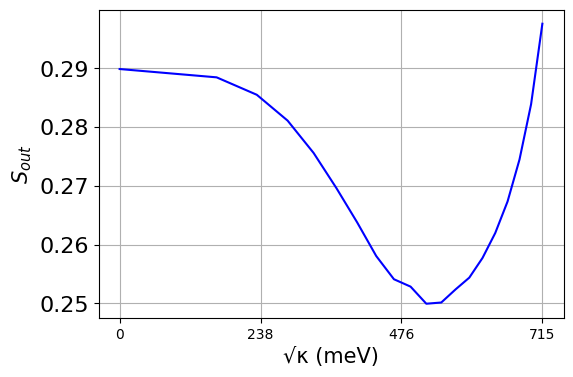

In [47]:
output_dir = "../images/entropy"
os.makedirs(output_dir, exist_ok=True)

# --------------------------------
#   PLOTTING ENTROPY vs. KAPPA
# --------------------------------

plt.figure(figsize=(6, 4))
kappa_meV = THz_to_meV(np.sqrt(kappa_values * scaling_factor))
plt.plot(kappa_meV, entropies, linestyle='-', color='b')
# plt.plot(kappa_meV, entropies_2, linestyle='-', color='r')

num_ticks = 4
kappa_ticks = np.linspace(kappa_meV[0], kappa_meV[-1], num_ticks)

# Set the ticks directly from kappa_values
plt.xticks(kappa_ticks, [f'{int(k)}' for k in kappa_ticks], fontsize=10)

plt.xlabel(f"√κ (meV)", fontsize=15)
plt.ylabel('$S_{out}$', fontsize=15)
plt.grid()

filename = f"entropy_gaussian_squeezed.png"
filepath = os.path.join(output_dir, filename)
fig.savefig(filepath, dpi=300, bbox_inches='tight')
plt.close(fig)